# Mobile Plan Revenue Analysis

You work as an analyst for the telecommunications operator Megaline. The company offers its customers two prepaid plans: Surf and Ultimate. The commercial department wants to know which of the two plans generates more revenue in order to adjust the advertising budget accordingly.

You are going to conduct a preliminary analysis of the plans based on a relatively small selection of customers. You will have data on 500 Megaline customers: who they are, where they are from, which plan they use, as well as the number of calls they made and text messages they sent in 2018. Your task is to analyze customer behavior and determine which prepaid plan generates more revenue.

## 1. Initialization

In [4]:
# Importing libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st

## 2. Loading Data

In [5]:
# Loading datasets
calls_df = pd.read_csv('megaline_calls.csv')
internet_df = pd.read_csv('megaline_internet.csv')
messages_df = pd.read_csv('megaline_messages.csv')
plans_df = pd.read_csv('megaline_plans.csv')
users_df = pd.read_csv('megaline_users.csv')

## 3. Preprocessing Data

### Plans

In [6]:
# Print general/summary information about the tariffs dataFrame
plans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 260.0+ bytes


In [7]:
# Print a sample of the data for the tariffs dataFrame
print(plans_df)

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  


### Data Correction

In [8]:
plans_df['mb_per_month_included'] = plans_df['mb_per_month_included'] / 1014 #convert mb to gb
print(plans_df['mb_per_month_included'][0])
print(plans_df['mb_per_month_included'][1])

15.14792899408284
30.29585798816568


### Users

In [9]:
# Print general/summary information about the users DataFrame
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [10]:
# Print a sample of the data for users
print(users_df.head(10))

   user_id first_name  last_name  age                                    city  \
0     1000   Anamaria      Bauer   45   Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28         Seattle-Tacoma-Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36    Las Vegas-Henderson-Paradise, NV MSA   
3     1003   Reynaldo    Jenkins   52                           Tulsa, OK MSA   
4     1004    Leonila   Thompson   40         Seattle-Tacoma-Bellevue, WA MSA   
5     1005      Livia    Shields   31     Dallas-Fort Worth-Arlington, TX MSA   
6     1006     Jesusa   Bradford   73  San Francisco-Oakland-Berkeley, CA MSA   
7     1007    Eusebio      Welch   42           Grand Rapids-Kentwood, MI MSA   
8     1008      Emely    Hoffman   53       Orlando-Kissimmee-Sanford, FL MSA   
9     1009      Gerry     Little   19  San Jose-Sunnyvale-Santa Clara, CA MSA   

     reg_date      plan  churn_date  
0  2018-12-24  ultimate         NaN  
1  2018-08-13      surf         

NOTE: The data type of the dates is defined as object, when it should be datetime.
The city names in the 'city' column are separated by a hyphen.
There are also missing values in the 'churn_date' column.

### Data Correction

In [11]:
# From 'object' data to 'datatime' format
users_df['reg_date'] = pd.to_datetime(users_df['reg_date'], format = '%Y-%m-%d')
users_df['churn_date'] = pd.to_datetime(users_df['churn_date'], format = '%Y-%m-%d')
print(f"users_df['reg_date']: {users_df['reg_date'].dtype}")
print(f"users_df['churn_date']: {users_df['churn_date'].dtype}")

users_df['reg_date']: datetime64[ns]
users_df['churn_date']: datetime64[ns]


### *Additional Corrections

In [12]:
# Replacing the hyphens with spaces
users_df['city'] = users_df['city'].str.replace('-',' ')
users_df['city'].head(10)
print()
# Checking for missing or duplicated values
print("Numero de valores duplicados:", users_df.duplicated().sum())
print("Numero de valores ausentes:", users_df.isna().sum())


Numero de valores duplicados: 0
Numero de valores ausentes: user_id         0
first_name      0
last_name       0
age             0
city            0
reg_date        0
plan            0
churn_date    466
dtype: int64


### Calls

In [13]:
# Print general/summary information about the calls DataFrame
calls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [14]:
# Imprime una muestra de datos para las llamadas
print(calls_df.head(20))

          id  user_id   call_date  duration
0    1000_93     1000  2018-12-27      8.52
1   1000_145     1000  2018-12-27     13.66
2   1000_247     1000  2018-12-27     14.48
3   1000_309     1000  2018-12-28      5.76
4   1000_380     1000  2018-12-30      4.22
5   1000_388     1000  2018-12-31      2.20
6   1000_510     1000  2018-12-27      5.75
7   1000_521     1000  2018-12-28     14.18
8   1000_530     1000  2018-12-28      5.77
9   1000_544     1000  2018-12-26      4.40
10  1000_693     1000  2018-12-31      4.31
11  1000_705     1000  2018-12-31     12.78
12  1000_735     1000  2018-12-29      1.70
13  1000_778     1000  2018-12-28      3.29
14  1000_826     1000  2018-12-26      9.96
15  1000_842     1000  2018-12-27      5.85
16    1001_0     1001  2018-09-06     10.06
17    1001_1     1001  2018-10-12      1.00
18    1001_2     1001  2018-10-17     15.83
19    1001_4     1001  2018-12-05      0.00


NOTE: The data type in the 'call_date' column can be converted to 'datetime'. The minute values in the 'duration' column appear to be incorrect.

### Data Correction

In [15]:
# From 'object' data to 'datatime' format
calls_df['call_date'] = pd.to_datetime(calls_df['call_date'], format = '%Y-%m-%d')
print(calls_df['call_date'].dtype)

datetime64[ns]


### *Additional Corrections

In [16]:
# In order to have the exaxt duration in minutes, it was converted the 'duration' column have a better representation
# the fraction of minutes is extracted (decimal) and rounds up or down.
calls_df['duration'] = np.ceil(calls_df['duration'])
print(calls_df['duration'].head(15))
# Checking for missing or duplicated values
print("Numero de valores duplicados:", calls_df.duplicated().sum())
print("Numero de valores ausentes:", calls_df.isna().sum())

0      9.0
1     14.0
2     15.0
3      6.0
4      5.0
5      3.0
6      6.0
7     15.0
8      6.0
9      5.0
10     5.0
11    13.0
12     2.0
13     4.0
14    10.0
Name: duration, dtype: float64
Numero de valores duplicados: 0
Numero de valores ausentes: id           0
user_id      0
call_date    0
duration     0
dtype: int64


### Messages

In [17]:
# Print general/summary information about the messages DataFrame
messages_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [18]:
# Print a sample of the data for the messages
print(messages_df.head(10))

         id  user_id message_date
0  1000_125     1000   2018-12-27
1  1000_160     1000   2018-12-31
2  1000_223     1000   2018-12-31
3  1000_251     1000   2018-12-27
4  1000_255     1000   2018-12-26
5  1000_346     1000   2018-12-29
6  1000_386     1000   2018-12-30
7  1000_413     1000   2018-12-31
8  1000_502     1000   2018-12-27
9  1000_525     1000   2018-12-28


NOTE: The data type in the 'call_date' column can be converted to 'datetime'. No duplicate or missing values were found.

### Data Correction

In [19]:
#From 'object' data to 'datatime' format
messages_df['message_date'] = pd.to_datetime(messages_df['message_date'], format = '%Y-%m-%d')
print(messages_df['message_date'].dtype)

datetime64[ns]


### *Additional Corrections

In [20]:
print("Numero de valores duplicados:", messages_df.duplicated().sum())
print("Numero de valores ausentes:", messages_df.isna().sum())

Numero de valores duplicados: 0
Numero de valores ausentes: id              0
user_id         0
message_date    0
dtype: int64


### Internet

In [21]:
# Print general/summary information about the internet DataFrame
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [22]:
# Print a sample of the data for internet traffic
print(internet_df.head(10))

         id  user_id session_date  mb_used
0   1000_13     1000   2018-12-29    89.86
1  1000_204     1000   2018-12-31     0.00
2  1000_379     1000   2018-12-28   660.40
3  1000_413     1000   2018-12-26   270.99
4  1000_442     1000   2018-12-27   880.22
5    1001_0     1001   2018-08-24   284.68
6    1001_3     1001   2018-12-09   656.04
7    1001_4     1001   2018-11-04    16.97
8   1001_10     1001   2018-11-27   135.18
9   1001_15     1001   2018-12-13   761.92


NOTA: The data type in the 'call_date' column can be converted to 'datetime'. No duplicate or missing values were found.

### Data Corrections

In [23]:
#From 'object' data to 'datatime' format
internet_df['session_date'] = pd.to_datetime(internet_df['session_date'], format = '%Y-%m-%d')
print(internet_df['session_date'].dtype)

datetime64[ns]


### *Additional Corrections

In [24]:
print("Numero de valores duplicados:", internet_df.duplicated().sum())
print("Numero de valores ausentes:", internet_df.isna().sum())

Numero de valores duplicados: 0
Numero de valores ausentes: id              0
user_id         0
session_date    0
mb_used         0
dtype: int64


## Study the conditions of the plans

In [25]:
# Print the conditions of the plan and make sure you understand them clearly
plans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      float64
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(3), int64(4), object(1)
memory usage: 260.0+ bytes


## Add data per user


In [26]:
# Calculate the number of calls made by each user per month. Save the result.
calls_df['month'] = calls_df['call_date'].dt.month # Extract the month from 'call_date'
monthly_calls_per_user = calls_df.groupby(['user_id', 'month'])['id'].count().reset_index() # Grouped by 'user_id' and 'month'
monthly_calls_per_user.columns = ['user_id', 'month', 'number_of_calls'] # Rename
print(monthly_calls_per_user)

      user_id  month  number_of_calls
0        1000     12               16
1        1001      8               27
2        1001      9               49
3        1001     10               65
4        1001     11               64
...       ...    ...              ...
2253     1498     12               39
2254     1499      9               41
2255     1499     10               53
2256     1499     11               45
2257     1499     12               65

[2258 rows x 3 columns]


In [27]:
# Calculate the number of minutes used by each user per month. Save the result.
min_used_monthly = calls_df.groupby(['user_id', 'month'])['duration'].sum().reset_index()
# Grouped by 'user_id' and 'month', and then sum the number of minutes per user
min_used_monthly.columns = ['user_id', 'month', 'minutes'] # Rename
print(min_used_monthly)

      user_id  month  minutes
0        1000     12    124.0
1        1001      8    182.0
2        1001      9    315.0
3        1001     10    393.0
4        1001     11    426.0
...       ...    ...      ...
2253     1498     12    339.0
2254     1499      9    346.0
2255     1499     10    385.0
2256     1499     11    308.0
2257     1499     12    496.0

[2258 rows x 3 columns]


In [28]:
# Calculate the number of messages sent by each user per month. Save the result.
messages_df['month'] = messages_df['message_date'].dt.month # Extract the month from 'c_date' from 'message_df'
sms_send_monthly = messages_df.groupby(['user_id', 'month'])['id'].count().reset_index()
# Grouped by 'user_id' and 'month', and then count the number of messages per user
sms_send_monthly.columns = ['user_id', 'month', 'number_messages'] # Rename
print(sms_send_monthly)

      user_id  month  number_messages
0        1000     12               11
1        1001      8               30
2        1001      9               44
3        1001     10               53
4        1001     11               36
...       ...    ...              ...
1801     1496      9               21
1802     1496     10               18
1803     1496     11               13
1804     1496     12               11
1805     1497     12               50

[1806 rows x 3 columns]


In [29]:
# Calculate the volume of Internet traffic used by each user per month. Save the result.
internet_df['month'] = internet_df['session_date'].dt.month # Extract the month from 'session_date' from 'internet_df'
internet_volume_monthly = internet_df.groupby(['user_id', 'month'])['mb_used'].sum().reset_index()
internet_volume_monthly['mb_used'] = internet_volume_monthly['mb_used'] / 1024 # Convert mb to gb
internet_volume_monthly['mb_used'] = np.ceil(internet_volume_monthly['mb_used']) # Rounded

# Grouped by 'user_id' and 'month', and sum the volume of mb used
internet_volume_monthly.columns = ['user_id', 'month', 'mb_used'] # Rename
print(internet_volume_monthly)

      user_id  month  mb_used
0        1000     12      2.0
1        1001      8      7.0
2        1001      9     14.0
3        1001     10     22.0
4        1001     11     19.0
...       ...    ...      ...
2272     1498     12     23.0
2273     1499      9     13.0
2274     1499     10     20.0
2275     1499     11     17.0
2276     1499     12     22.0

[2277 rows x 3 columns]


In [30]:
# Merge the call, minutes, messages, and Internet data based on user_id and month
# 'monthly_calls_per_user', 'min_used_monthly', 'sms_send_monthly', 'internet_volume_monthly' 
user_info_monthly_0 = monthly_calls_per_user.merge(min_used_monthly)
user_info_monthly_1 = user_info_monthly_0.merge(sms_send_monthly)
user_info_monthly_2 = user_info_monthly_1.merge(internet_volume_monthly) # Merge df x df
print(user_info_monthly_2)

      user_id  month  number_of_calls  minutes  number_messages  mb_used
0        1000     12               16    124.0               11      2.0
1        1001      8               27    182.0               30      7.0
2        1001      9               49    315.0               44     14.0
3        1001     10               65    393.0               53     22.0
4        1001     11               64    426.0               36     19.0
...       ...    ...              ...      ...              ...      ...
1754     1496      9               52    414.0               21     17.0
1755     1496     10               46    317.0               18     14.0
1756     1496     11               39    308.0               13      9.0
1757     1496     12               40    294.0               11     17.0
1758     1497     12               54    300.0               50     11.0

[1759 rows x 6 columns]


In [31]:
# Add the plan information
user_info_monthly_3 = user_info_monthly_2.merge(users_df[['user_id', 'plan']])
print(user_info_monthly_3.head(15))

    user_id  month  number_of_calls  minutes  number_messages  mb_used  \
0      1000     12               16    124.0               11      2.0   
1      1001      8               27    182.0               30      7.0   
2      1001      9               49    315.0               44     14.0   
3      1001     10               65    393.0               53     22.0   
4      1001     11               64    426.0               36     19.0   
5      1001     12               56    412.0               44     19.0   
6      1002     10               11     59.0               15      7.0   
7      1002     11               55    386.0               32     19.0   
8      1002     12               47    384.0               41     15.0   
9      1003     12              149   1104.0               50     27.0   
10     1004      5               21    193.0                7      7.0   
11     1004      6               44    275.0               18     21.0   
12     1004      7               49   

In [32]:
# Calculate the monthly revenue for each user
def calculate_monthly_income(row):
    plan_name = row['plan']
    minutes = row['minutes']
    messages = row['number_messages']
    mb_used = row['mb_used']
    
    total_cost = 0 

    if plan_name == 'surf':
        total_cost += 20 # 'usd_monthly_pay' for surf plan
        if minutes > 500:
            total_cost += (minutes - 500) * 0.03
        if messages > 50:
            total_cost += (messages - 50) * 0.03
        if mb_used > plans_df['mb_per_month_included'][0]: #'mb_used' & mb_per_month_included' already in GB
            total_cost += (mb_used - plans_df['mb_per_month_included'][0]) * 10
    elif plan_name == 'ultimate':
        total_cost += 70 # 'usd_monthly_pay' for ultimate plan
        if minutes > 3000:
            total_cost += (minutes - 3000) * 0.01
        if messages > 1000:
            total_cost += (messages - 1000) * 0.01
        if mb_used > plans_df['mb_per_month_included'][1]: # Already converted to GB
            total_cost += (mb_used - plans_df['mb_per_month_included'][1]) * 7

    return total_cost

user_info_monthly_3['monthly_income'] = user_info_monthly_3.apply(calculate_monthly_income, axis = 1)# New column in the user data df
print(user_info_monthly_3.head(15))

    user_id  month  number_of_calls  minutes  number_messages  mb_used  \
0      1000     12               16    124.0               11      2.0   
1      1001      8               27    182.0               30      7.0   
2      1001      9               49    315.0               44     14.0   
3      1001     10               65    393.0               53     22.0   
4      1001     11               64    426.0               36     19.0   
5      1001     12               56    412.0               44     19.0   
6      1002     10               11     59.0               15      7.0   
7      1002     11               55    386.0               32     19.0   
8      1002     12               47    384.0               41     15.0   
9      1003     12              149   1104.0               50     27.0   
10     1004      5               21    193.0                7      7.0   
11     1004      6               44    275.0               18     21.0   
12     1004      7               49   

## Study user behavior

Calculate some descriptive statistics for the aggregated and merged data that are useful and provide an overall picture captured by the data. Draw helpful graphs to facilitate understanding. Since the main task is to compare the plans and decide which is more profitable, the statistics and graphs should be calculated by plan.

### Calls

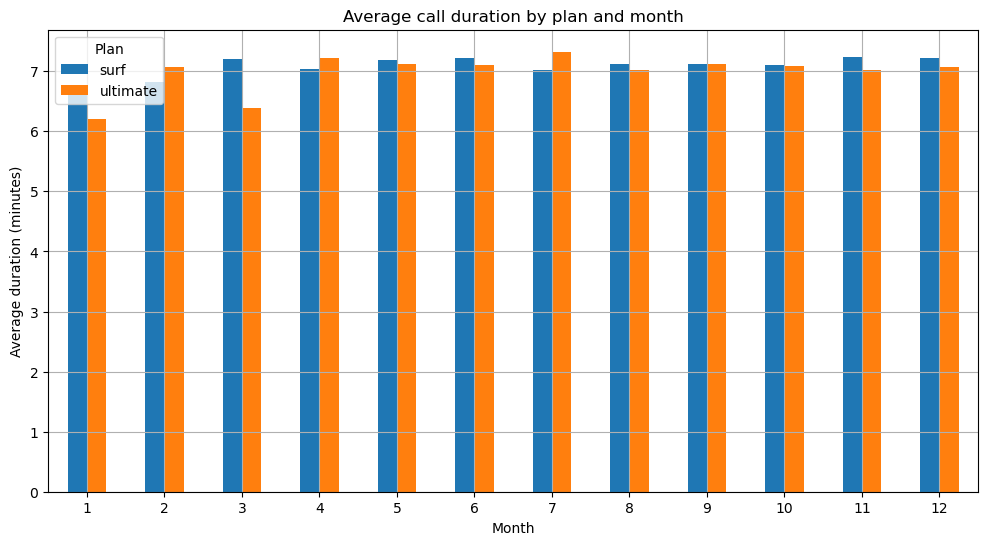

In [33]:
# Compare the average call duration for each plan and for each month. Plot a bar chart to visualize it.
mean_calls = calls_df.groupby(['user_id', 'month'])['duration'].mean().reset_index()
mean_calls_1 = mean_calls.merge(users_df[['user_id', 'plan']])

pivot_data = mean_calls_1.pivot_table(index = 'month', columns = 'plan', values = 'duration')

# Plot the bar chart
pivot_data.plot(kind = 'bar', figsize = (12, 6), grid = True)
plt.title('Average call duration by plan and month')
plt.xlabel('Month')
plt.ylabel('Average duration (minutes)')
plt.xticks(rotation = 0)
plt.legend(title = 'Plan')
plt.show()

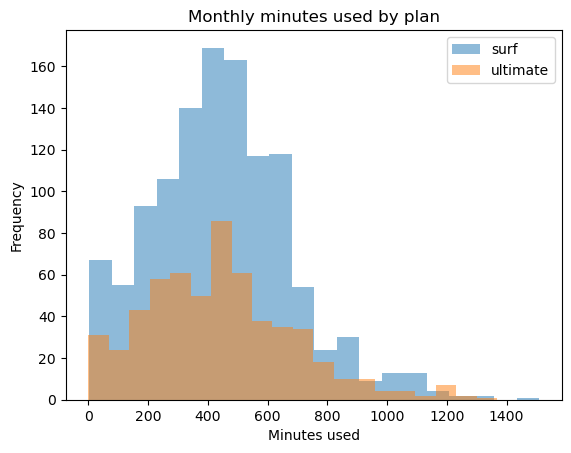

In [34]:
# Compare the monthly number of minutes used by users of each plan. Plot a histogram.
surf_users = user_info_monthly_3[user_info_monthly_3['plan'] == 'surf'] # filter data for each plan
ultimate_users = user_info_monthly_3[user_info_monthly_3['plan'] == 'ultimate']

plt.hist(surf_users['minutes'], bins = 20, alpha = 0.5, label = 'surf')
plt.hist(ultimate_users['minutes'], bins = 20, alpha = 0.5, label = 'ultimate')
plt.title('Monthly minutes used by plan')
plt.xlabel('Minutes used')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [35]:
# Calculate the mean and variance of the monthly call duration.
monthly_call_stats = calls_df.groupby(['user_id', 'month'])['duration'].agg(['mean', 'var']) # Group data by user_id and month
monthly_call_stats = monthly_call_stats.rename(columns = {'mean': 'mean_duration', 'var': 'variance_duration'}) # Rename
print(monthly_call_stats)

               mean_duration  variance_duration
user_id month                                  
1000    12          7.750000          18.866667
1001    8           6.740741          22.584046
        9           6.428571          29.208333
        10          6.046154          28.825962
        11          6.656250          42.260913
...                      ...                ...
1498    12          8.692308          37.481781
1499    9           8.439024          33.202439
        10          7.264151          48.236575
        11          6.844444          29.088889
        12          7.630769          35.924038

[2258 rows x 2 columns]


C:\Users\mauro\AppData\Local\Temp\ipykernel_2936\572283011.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([merged_data[merged_data['plan'] == 'surf']['mean_duration'],


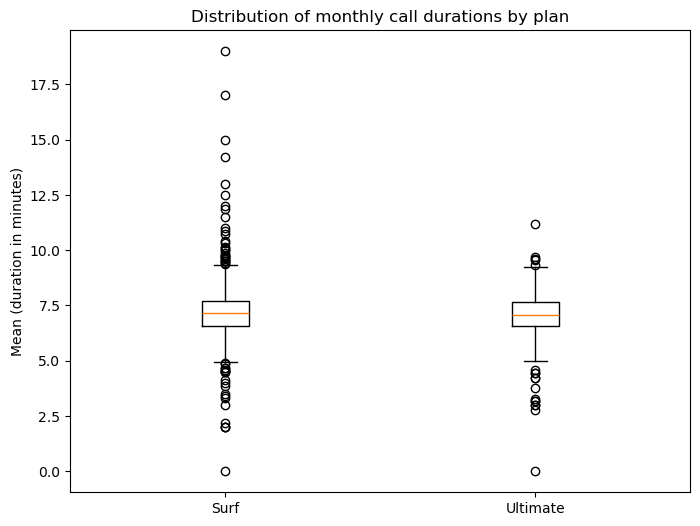

In [36]:
# Plot a box plot to visualize the distribution of the monthly call duration.
monthly_call_stats = monthly_call_stats.reset_index() # Reset index and merge with user data to include 'plan'
merged_data = pd.merge(monthly_call_stats, users_df[['user_id', 'plan']], on = 'user_id', how = 'left')

plt.figure(figsize=(8, 6))
plt.boxplot([merged_data[merged_data['plan'] == 'surf']['mean_duration'],
             merged_data[merged_data['plan'] == 'ultimate']['mean_duration']],
            labels=['Surf', 'Ultimate'])
plt.title('Distribution of monthly call durations by plan')
plt.ylabel('Mean (duration in minutes)')
plt.show()

In conclusion, user behavior regarding calls does vary. 'Ultimate' users make a higher number of calls but of shorter duration (likely due to their greater available call time), whereas 'Surf' users make fewer calls but with longer duration.

### Messages

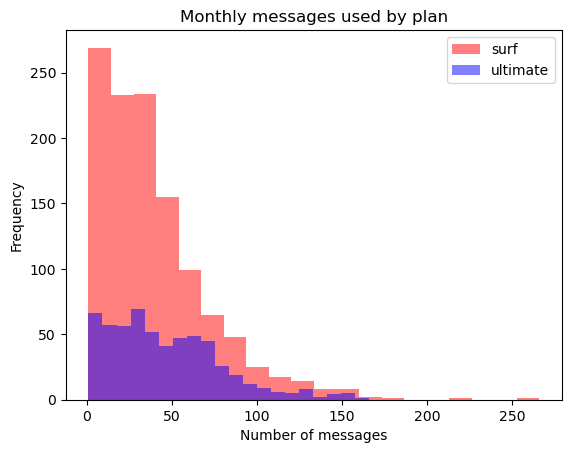

In [37]:
# Compare the number of messages that users of each plan tend to send each month.
plt.hist(surf_users['number_messages'], bins = 20, color = 'red', alpha = 0.5, label = 'surf') # Filtered data used before (surf_users & ultimate users)
plt.hist(ultimate_users['number_messages'], bins = 20, color = 'blue', alpha = 0.5, label = 'ultimate')
plt.title('Monthly messages used by plan')
plt.xlabel('Number of messages')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [38]:
print(surf_users['number_messages'].describe())
print()
print(ultimate_users['number_messages'].describe())

count    1180.000000
mean       39.489831
std        32.314360
min         1.000000
25%        16.000000
50%        32.000000
75%        53.000000
max       266.000000
Name: number_messages, dtype: float64

count    579.000000
mean      46.455959
std       32.930135
min        1.000000
25%       21.000000
50%       41.000000
75%       66.000000
max      166.000000
Name: number_messages, dtype: float64


In conclusion, the histogram shows a difference in user behavior regarding messages. The analysis indicates that users on the 'Ultimate' plan send more messages on average than those on the 'Surf' plan (likely due to the higher number of messages included in their plan). On the other hand, 'Surf' users tend to be more moderate in their usage (probably to avoid additional charges).

### Internet

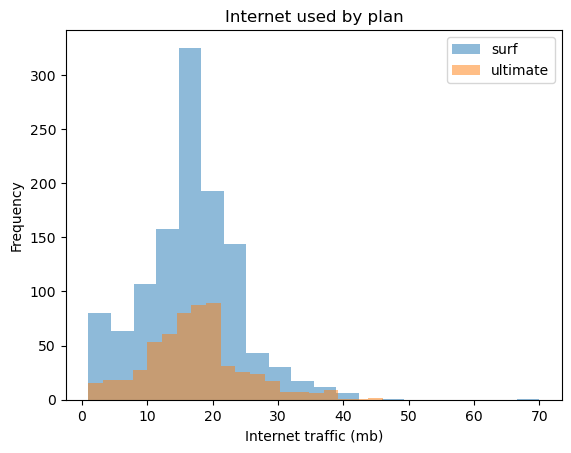

In [39]:
# Compare the amount of Internet traffic consumed by users by plan.
plt.hist(surf_users['mb_used'], bins = 20, alpha = 0.5, label = 'surf') # Filtered data used before (surf_users & ultimate users)
plt.hist(ultimate_users['mb_used'], bins = 20, alpha = 0.5, label = 'ultimate')
plt.title('Internet used by plan')
plt.xlabel('Internet traffic (mb)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [40]:
surf_users['mb_used'].describe()

count    1180.000000
mean       16.752542
std         7.550662
min         1.000000
25%        13.000000
50%        17.000000
75%        21.000000
max        70.000000
Name: mb_used, dtype: float64

In [41]:
ultimate_users['mb_used'].describe()

count    579.000000
mean      17.343696
std        7.494935
min        1.000000
25%       13.000000
50%       17.000000
75%       21.000000
max       46.000000
Name: mb_used, dtype: float64

In conclusion, the graph and statistics show that users of the 'Surf' plan, despite having a lower data limit, tend to consume a higher amount of internet MB more frequently than users of the 'Ultimate' plan.

## Revenue

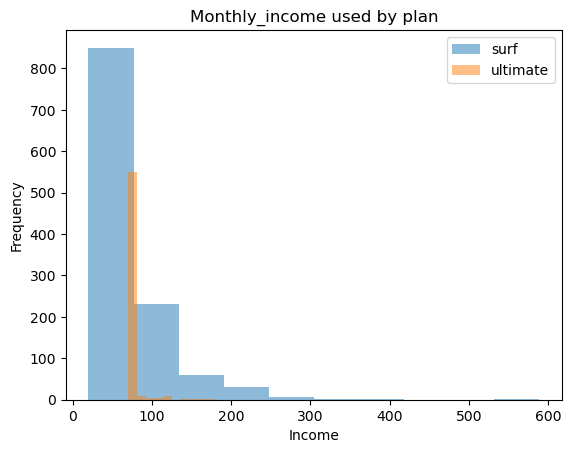

In [42]:
plt.hist(surf_users['monthly_income'], bins = 10, alpha = 0.5, label = 'surf') # Filtered data used before (surf_users & ultimate users)
plt.hist(ultimate_users['monthly_income'], alpha = 0.5, bins = 10, label = 'ultimate')
plt.title('Monthly_income used by plan')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [43]:
surf_users['monthly_income'].describe()

count    1180.000000
mean       59.543309
std        53.159968
min        20.000000
25%        20.022500
50%        39.555710
75%        78.753210
max       588.890710
Name: monthly_income, dtype: float64

In [44]:
ultimate_users['monthly_income'].describe()

count    579.000000
mean      72.130668
std       10.639104
min       70.000000
25%       70.000000
50%       70.000000
75%       70.000000
max      179.928994
Name: monthly_income, dtype: float64

In conclusion, the graph and statistics show that users of the 'Surf' plan have a higher number of users who exceed the base monthly charge (and therefore tend to generate more additional charges). On the other hand, the 'Ultimate' plan has a higher and more stable base revenue (many users do not usually generate charges beyond the base fee).

## Test the statistical hypotheses.

Test the hypothesis that the average revenues from users of the Ultimate and Surf calling plans are different.

In [45]:
# Test the hypotheses
# H0 = surf_users['monthly_income'] = ultimate_users['monthly_income']
# H1 = surf_users['monthly_income'] != ultimate_users['monthly_income']

alpha = 0.05 # There is a 5% probability of rejecting the null hypothesis.

# Two-tailed hypothesis
results = st.ttest_ind(surf_users['monthly_income'], ultimate_users['monthly_income'])

print('valor p:', results.pvalue)

if (results.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("We cannot reject the null hypothesis.")

valor p: 1.9597376215605607e-08
We reject the null hypothesis


Test the hypothesis that the average revenue of users from the NY-NJ area is different from that of users from other regions.

In [46]:
# Merge 'city' column from users_df into user_info_monthly_3
user_info_monthly_3 = pd.merge(user_info_monthly_3, users_df[['user_id', 'city']], on = 'user_id', how = 'left',suffixes = ('_x', ''))
user_info_monthly_3.info()
print('---' * 15)
ny_nj_users = user_info_monthly_3[user_info_monthly_3['city'].str.contains('NY NJ')] # Filter data for NY-NJ users
other_regions_users = user_info_monthly_3[~user_info_monthly_3['city'].str.contains('NY NJ')] # Filter data for users in other regions

# Test the hypotheses
# H0 = ny_nj_users['monthly_income'] = other_regions_users['monthly_income']
# H1 = ny_nj_users['monthly_income'] != other_regions_users['monthly_income']

alpha = 0.05

# Two-tailed hypothesis
results = st.ttest_ind(ny_nj_users['monthly_income'], other_regions_users['monthly_income'])
print('valor p:', results.pvalue)

if (results.pvalue < alpha):
    print("We reject the null hypothesis.")
else:
    print("We cannot reject the null hypothesis.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1759 entries, 0 to 1758
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          1759 non-null   int64  
 1   month            1759 non-null   int32  
 2   number_of_calls  1759 non-null   int64  
 3   minutes          1759 non-null   float64
 4   number_messages  1759 non-null   int64  
 5   mb_used          1759 non-null   float64
 6   plan             1759 non-null   object 
 7   monthly_income   1759 non-null   float64
 8   city             1759 non-null   object 
dtypes: float64(3), int32(1), int64(3), object(2)
memory usage: 116.9+ KB
---------------------------------------------
valor p: 0.008404475675090024
We reject the null hypothesis.


## General conclusion

Two plans from the company Megaline, 'Surf' and 'Ultimate', were analyzed to determine which generates more revenue and to understand user behavior. First, the data from all DataFrames were reviewed and cleaned.

It was observed that users on the 'Ultimate' plan tend to talk longer and use more internet data than those on the 'Surf' plan. Regarding messages, there are not many differences between the two groups. Many users exceed the included minutes and data, which generates additional revenue for Megaline.

Although the 'Ultimate' plan has a higher monthly fee, it generates higher average revenue per user because these users tend to use more minutes and data. Meanwhile, 'Surf' users also tend to exceed their limits, resulting in additional charges as well. Statistical analysis confirms that the average revenues of both plans are different.

Finally, two hypothesis tests were conducted using an independent samples t-test with a 5% significance level. The first test, comparing the revenues of users from the Surf and Ultimate plans, resulted in rejecting the null hypothesis (indicating a significant difference between the average revenues generated by the two plans). The second test, comparing the average revenues of users from the NY-NJ area with those from other regions, also resulted in rejecting the null hypothesis (showing a significant difference in revenues between users from NY-NJ and users from other regions).